# Diabetes Detection Dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder

## Reading dataset and getting Info

In [4]:
# Reading Dataset
df = pd.read_csv('diabetes.csv')

In [5]:
df.shape

(768, 9)

In [7]:
df.sample(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
522,6,114,0,0,0,0.0,0.189,26,0
295,6,151,62,31,120,35.5,0.692,28,0
190,3,111,62,0,0,22.6,0.142,21,0
732,2,174,88,37,120,44.5,0.646,24,1
662,8,167,106,46,231,37.6,0.165,43,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [9]:
# Check null values
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [10]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


- the min value in  5 columns = 0 (Glucose, BloodPressure, Skin Thickness, Insulin, BMI)
- In skin Thickness and Insulin Column less than or equal 25% of the data are null values
- look at the maximum Insulin Value = 846 wich is too high u will never find a person with this insulin value

  all this an errors in data collection

In [15]:
pd.DataFrame({"Count": df.shape[0],
             "Null": df.isna().sum(),
             "Null %": df.isna().mean()*100,
             'No_unique_value': df.nunique()})

,Count,Null,Null %,No_unique_value
Pregnancies,768,0,0.0,17
Glucose,768,0,0.0,136
BloodPressure,768,0,0.0,47
SkinThickness,768,0,0.0,51
Insulin,768,0,0.0,186
BMI,768,0,0.0,248
DiabetesPedigreeFunction,768,0,0.0,517
Age,768,0,0.0,52
Outcome,768,0,0.0,2


In [ ]:
# df[df['SkinThickness'] == 0].value_counts().sum()
df[df['Insulin'] == 0].value_counts().sum()

374

## Handling Missing Data (Nulls)

#### Convert those 0's values into Nan Values as they cannot be zero in these 5 columns to determine how many missing values in each feature in our data

In [22]:
df[['Glucose', 'BloodPressure', 'BMI','SkinThickness','Insulin']] = df[['Glucose', 'BloodPressure',
                  'BMI', 'SkinThickness', 'Insulin']].replace(0, np.nan)

In [24]:
# After replacing 0 values with NaN
df.isna().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

### Handling Missing Data

In [35]:
def median_target(column):
    temp = df.groupby('Outcome')[column].median()
    df.loc[(df['Outcome'] == 0 ) & (df[column].isnull()), column] = temp[0]
    df.loc[(df['Outcome'] == 1 ) & (df[column].isnull()), column] = temp[1]

In [36]:
columns_to_Fill = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
for column in columns_to_Fill:
    median_target(column)

In [37]:
# After filling missing values
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [38]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.677083,72.389323,29.089844,141.753906,32.434635,0.471876,33.240885,0.348958
std,3.369578,30.464161,12.106039,8.890820,89.100847,6.880498,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,102.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,28.000000,102.500000,32.050000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,169.500000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [34]:
df.groupby('Outcome')['Glucose'].median()

Outcome
0    107.0
1    140.0
Name: Glucose, dtype: float64

In [29]:
df.groupby('Outcome')['Glucose'].mean()

Outcome
0    110.643863
1    142.319549
Name: Glucose, dtype: float64

In [33]:
(df['Glucose'].isna()), ['Glucose']

(0      False
 1      False
 2      False
 3      False
 4      False
        ...  
 763    False
 764    False
 765    False
 766    False
 767    False
 Name: Glucose, Length: 768, dtype: bool,
 ['Glucose'])

## Detection of Outliers

In [43]:
def detect_outliers(df, columns, threshold=1.5):
    
    outliers_indices = {}
    for col in columns:
        Q1 = np.percentile(df[col], 25) # 25th percenile
        Q3 = np.percentile(df[col], 75) # 75th percentile
        IQR = Q3 - Q1
        lower_bound = Q1 - (threshold * IQR)
        upper_bound = Q3 + (threshold * IQR)
        
        # Find the outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index.tolist()
        outliers_indices[col] = outliers
        
    return outliers_indices

numerical_columns = df.columns.to_list()[:-1]
outliers_iqr = detect_outliers(df, numerical_columns, threshold=1.5)

for col, indices in outliers_iqr.items():
    print(f"{col}: {len(indices)} outliers detected")

Pregnancies: 4 outliers detected
Glucose: 0 outliers detected
BloodPressure: 14 outliers detected
SkinThickness: 87 outliers detected
Insulin: 51 outliers detected
BMI: 8 outliers detected
DiabetesPedigreeFunction: 29 outliers detected
Age: 9 outliers detected


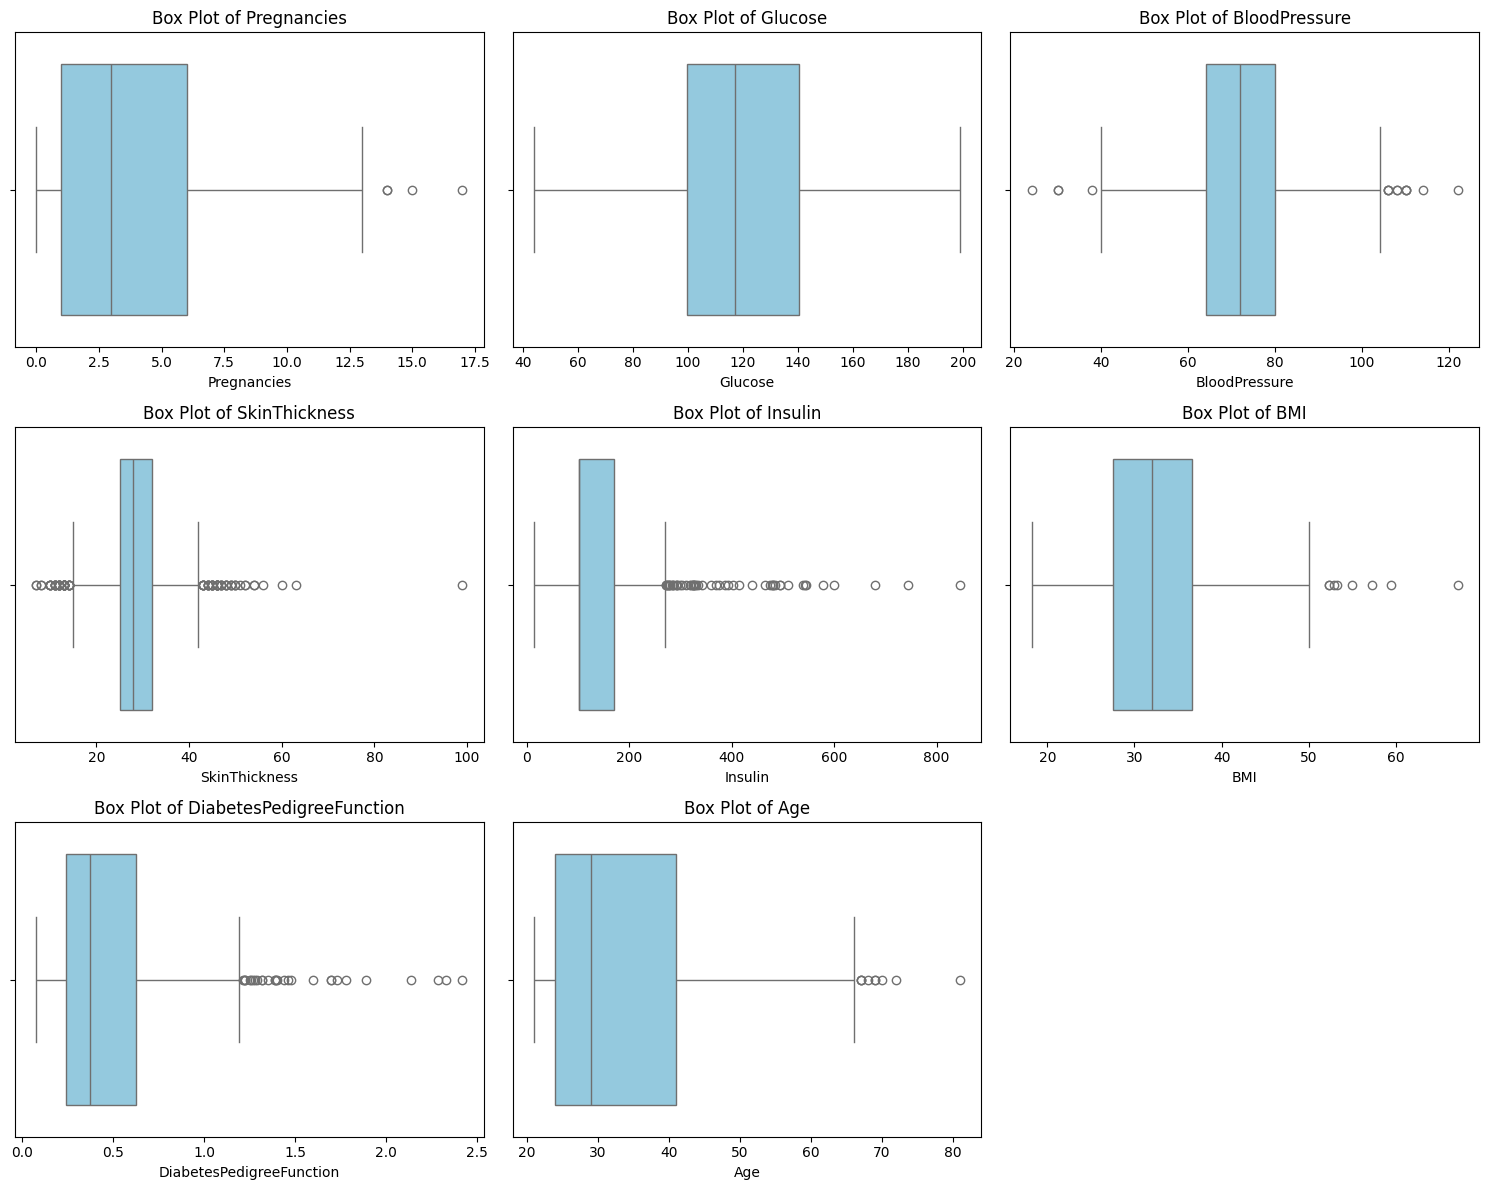

In [45]:
plt.figure(figsize=(15, 12))

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)  
    sns.boxplot(x = df[col], color = "skyblue")
    plt.title(f"Box Plot of {col}")

plt.tight_layout() 
plt.show()

In [46]:
def remove_outliers(df, columns, threshold=1.5):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)  # First quartile (25%)
        Q3 = df_clean[col].quantile(0.75)  # Third quartile (75%)
        IQR = Q3 - Q1  # Interquartile range
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        df_clean = df_clean[(df_clean[col] > lower_bound) & (df_clean[col] < upper_bound)]
    
    return df_clean

df_cleaned = remove_outliers(df, numerical_columns)

In [48]:
# After removing Outliers new dataset
df_cleaned

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50,1
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31,0
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
5,5,116.0,74.0,27.0,102.5,25.6,0.201,30,0
...,...,...,...,...,...,...,...,...,...
762,9,89.0,62.0,27.0,102.5,22.5,0.142,33,0
764,2,122.0,70.0,27.0,102.5,36.8,0.340,27,0
765,5,121.0,72.0,23.0,112.0,26.2,0.245,30,0
766,1,126.0,60.0,32.0,169.5,30.1,0.349,47,1


In [56]:

df_cleaned.shape

(579, 9)

# Cleaned Dataset Boxplot To Show Outliers

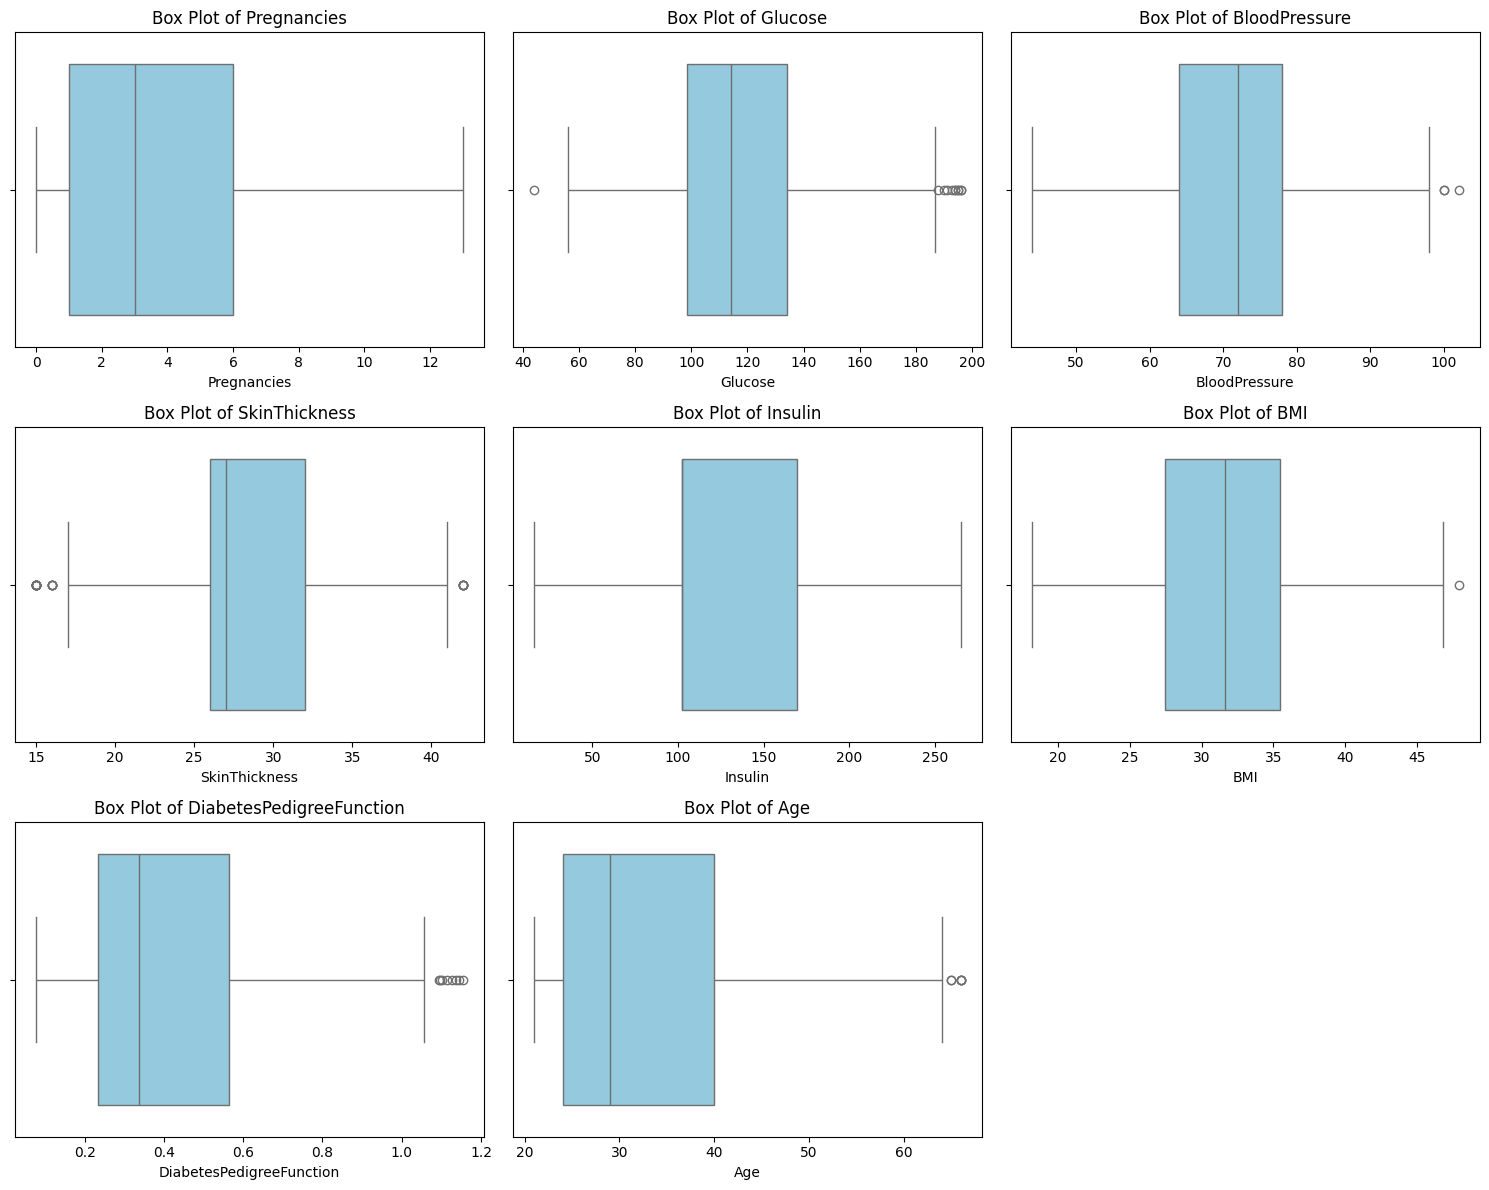

In [59]:
plt.figure(figsize=(15, 12))

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i) 
    sns.boxplot(x = df_cleaned[col], color = "skyblue")
    plt.title(f"Box Plot of {col}")

plt.tight_layout()
plt.show()

In [60]:
df_cleaned.reset_index(inplace = True , drop = True)
df_cleaned.sample(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
401,0,111.0,65.0,27.0,102.5,24.6,0.660,31,0
17,9,119.0,80.0,35.0,169.5,29.0,0.263,29,1
261,8,126.0,88.0,36.0,108.0,38.5,0.349,49,0
510,4,125.0,80.0,32.0,169.5,32.3,0.536,27,1
272,13,129.0,74.5,30.0,169.5,39.9,0.569,44,1


In [61]:
# Info
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 579 entries, 0 to 578
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               579 non-null    int64  
 1   Glucose                   579 non-null    float64
 2   BloodPressure             579 non-null    float64
 3   SkinThickness             579 non-null    float64
 4   Insulin                   579 non-null    float64
 5   BMI                       579 non-null    float64
 6   DiabetesPedigreeFunction  579 non-null    float64
 7   Age                       579 non-null    int64  
 8   Outcome                   579 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 40.8 KB


In [58]:
detect_outliers(df, numerical_columns, threshold=1.5)

{'Pregnancies': [88, 159, 298, 455],
 'Glucose': [],
 'BloodPressure': [18,
  43,
  84,
  106,
  125,
  177,
  362,
  549,
  597,
  599,
  658,
  662,
  672,
  691],
 'SkinThickness': [8,
  16,
  32,
  39,
  50,
  55,
  57,
  68,
  80,
  86,
  99,
  120,
  130,
  134,
  150,
  155,
  169,
  177,
  191,
  197,
  198,
  211,
  252,
  254,
  273,
  275,
  279,
  286,
  289,
  293,
  307,
  313,
  316,
  320,
  335,
  340,
  353,
  370,
  374,
  375,
  382,
  385,
  392,
  393,
  409,
  422,
  428,
  432,
  434,
  444,
  445,
  446,
  447,
  450,
  458,
  465,
  466,
  476,
  519,
  532,
  539,
  548,
  565,
  575,
  579,
  580,
  585,
  591,
  594,
  595,
  609,
  617,
  625,
  639,
  657,
  661,
  662,
  663,
  665,
  671,
  689,
  693,
  698,
  710,
  718,
  753,
  763],
 'Insulin': [8,
  13,
  53,
  54,
  56,
  111,
  139,
  144,
  153,
  162,
  186,
  199,
  206,
  215,
  220,
  228,
  231,
  247,
  248,
  258,
  279,
  286,
  296,
  360,
  364,
  370,
  375,
  388,
  392,
  395,
  40

In [39]:
df.columns.to_list()[:-1]

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [41]:
df.iloc[:,:-1]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33
...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.0,180.0,32.9,0.171,63
764,2,122.0,70.0,27.0,102.5,36.8,0.340,27
765,5,121.0,72.0,23.0,112.0,26.2,0.245,30
766,1,126.0,60.0,32.0,169.5,30.1,0.349,47


## EDA of Data and Get insights

The number of people who have ediabetes in Pie Chart

In [67]:
# import plotly.express as px
# import plotly.io as pio

# fig = px.pie(values = df_cleaned['Outcome'].value_counts(),
#              names = ['Have No Diabetes','Have Diabetes'],
#              template = 'plotly_dark',
#              title = 'Percentage of diabetics in the data'
#              ).update_traces(textinfo='label+percent')
# pio.renderers.default = 'iframe'
# fig.show()

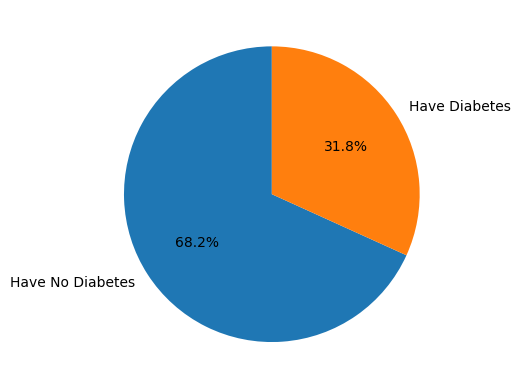

In [77]:
plt.pie(df_cleaned['Outcome'].value_counts(), labels = ['Have No Diabetes',
                        'Have Diabetes'], autopct='%1.1f%%', startangle=90)

plt.show()

In [69]:
df_cleaned['Outcome'].value_counts(normalize=True)

Outcome
0    0.682211
1    0.317789
Name: proportion, dtype: float64

- There are 68% healthy people and 32 % sick people are in the data

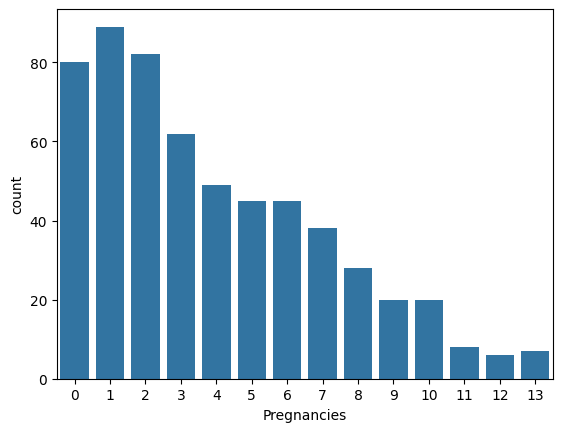

In [72]:
sns.barplot(df_cleaned['Pregnancies'].value_counts())
plt.show()

- #### Distributions of 'Glucose' ,'BloodPressure' ,'SkinThickness' ,'Insulin' ,'BMI' ,'DiabetesPedigreeFunction' and Age

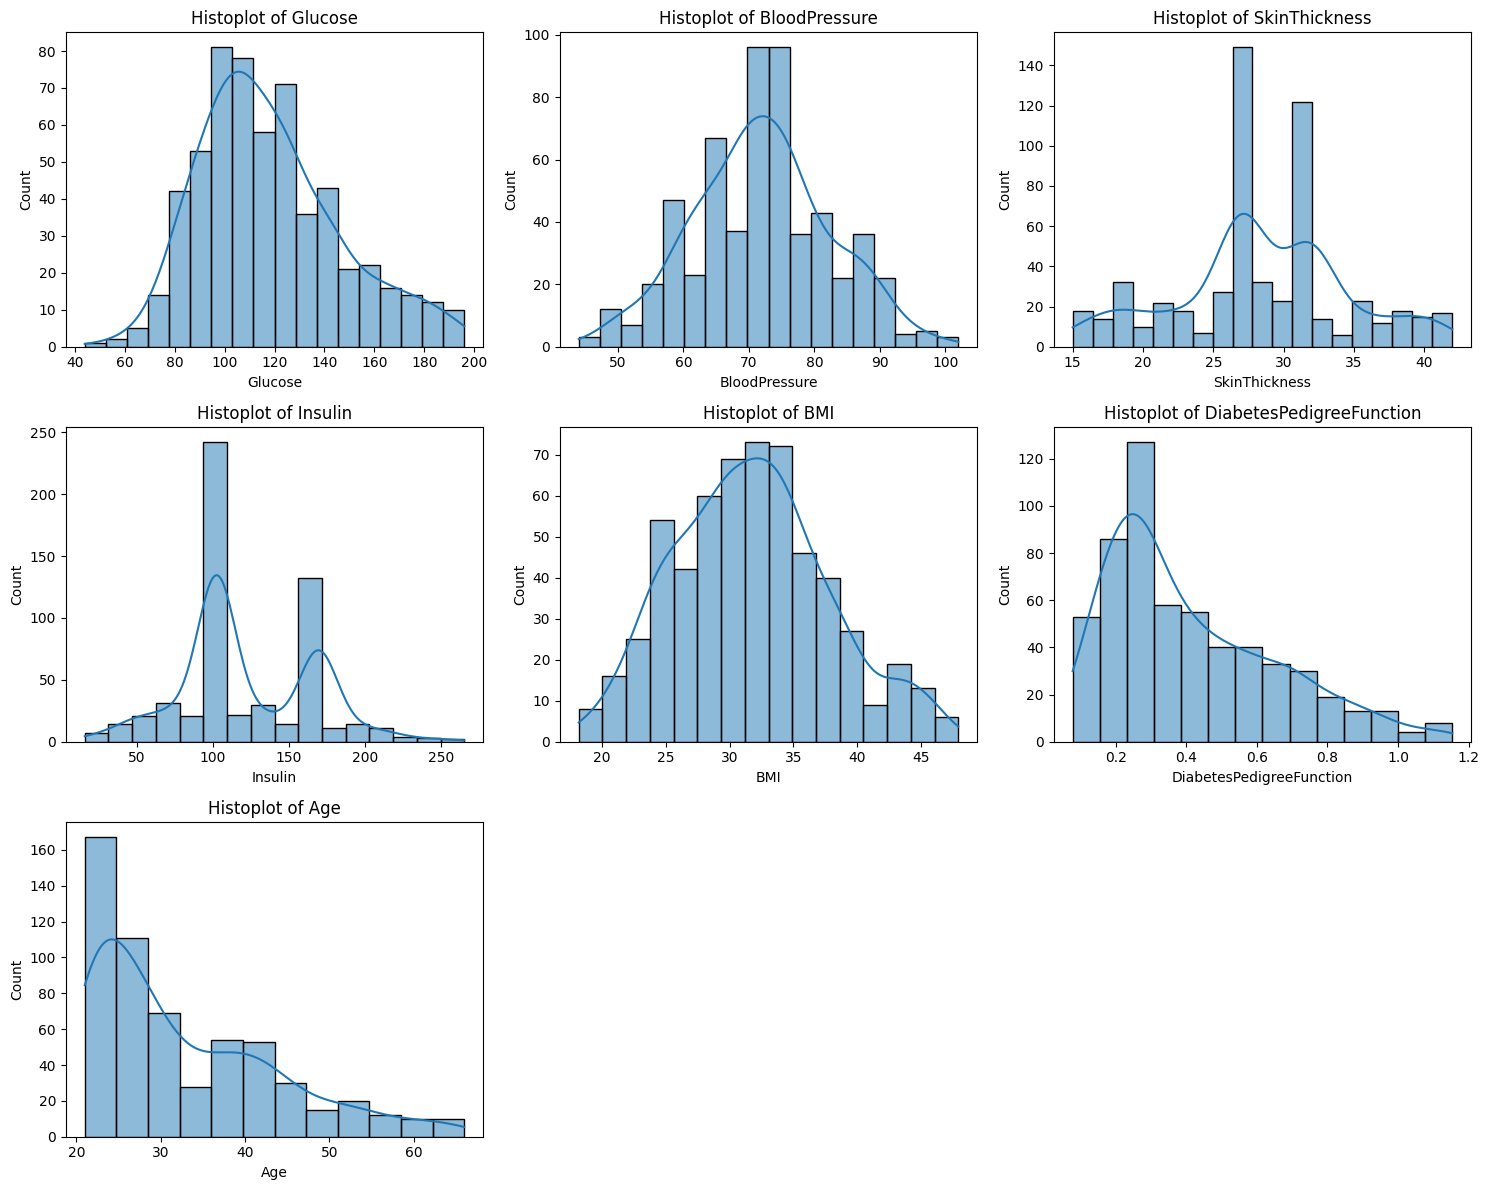

In [78]:
plt.figure(figsize=(15, 12))
columns_histo = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']

for i, col in enumerate(columns_histo, 1):
    plt.subplot(3, 3, i) 
    sns.histplot(df_cleaned[col],kde=True)
    plt.title(f"Histoplot of {col}")

plt.tight_layout()
plt.show()

In [118]:
df_cleaned

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50,1
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31,0
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,5,116.0,74.0,27.0,102.5,25.6,0.201,30,0
...,...,...,...,...,...,...,...,...,...
574,9,89.0,62.0,27.0,102.5,22.5,0.142,33,0
575,2,122.0,70.0,27.0,102.5,36.8,0.340,27,0
576,5,121.0,72.0,23.0,112.0,26.2,0.245,30,0
577,1,126.0,60.0,32.0,169.5,30.1,0.349,47,1


## Data Preprocessing

- Assign feature and target variables as X, y

In [81]:
x = df_cleaned.drop(columns=['Outcome'], axis = 1)
y = df_cleaned['Outcome']

In [82]:
# Splitting Data into Train and Test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [83]:
print(f'Shape of X_Train {x_train.shape}')
print(f'Shape of X_Test {x_test.shape}')
print(f'Shape of Y_Train {y_train.shape}')
print(f'Shape of Y_Test {y_test.shape}')

Shape of X_Train (463, 8)
Shape of X_Test (116, 8)
Shape of Y_Train (463,)
Shape of Y_Test (116,)


## Build Models

## Use Different Models Algorithm

In [87]:
def kfolds(model, model_name):
    model = cross_val_score(model, x,y, cv=5)
    model_score = np.average(model)
    print(f"{model_name} score on cross validation: {model_score * 100}%")

def train(model, model_name):
    model.fit(x_train, y_train)
    model_train_score = model.score(x_train, y_train)
    model_test_score = model.score(x_test, y_test)
    print(f"{model_name} model score on Training data: {model_train_score * 100}%\n{model_name} model score on Testing data: {model_test_score * 100}%")

    
def class_report(model):
    y_pred = model.predict(x_test)
    print(classification_report(y_test, y_pred))

### Logistic Regression

In [88]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
kfolds(lr, "Logistic Regression")
train(lr, "Logistic Regression")

Logistic Regression score on cross validation: 86.70014992503748%
Logistic Regression model score on Training data: 87.25701943844493%
Logistic Regression model score on Testing data: 87.06896551724138%


In [89]:
class_report(lr)

              precision    recall  f1-score   support

           0       0.89      0.93      0.91        81
           1       0.81      0.74      0.78        35

    accuracy                           0.87       116
   macro avg       0.85      0.83      0.84       116
weighted avg       0.87      0.87      0.87       116



In [91]:
# ConfusionMatrixDisplay.from_estimator(lr,
#                                        X_test,
#                                        y_test,
#                                        xticks_rotation=45
#     );

### Random Forest 

In [92]:
rf = RandomForestClassifier()
kfolds(rf, "Random Forest")
train(rf, "Random Forest")

Random Forest score on cross validation: 89.98650674662669%
Random Forest model score on Training data: 100.0%
Random Forest model score on Testing data: 88.79310344827587%


In [93]:
class_report(rf)

              precision    recall  f1-score   support

           0       0.90      0.95      0.92        81
           1       0.87      0.74      0.80        35

    accuracy                           0.89       116
   macro avg       0.88      0.85      0.86       116
weighted avg       0.89      0.89      0.89       116



### Decision Tree

In [103]:
dt_model = DecisionTreeClassifier()
kfolds(dt_model, "Decision Tree")
train(dt_model, "Decision Tree")

Decision Tree score on cross validation: 87.91604197901049%
Decision Tree model score on Training data: 100.0%
Decision Tree model score on Testing data: 85.34482758620689%


In [104]:
class_report(dt_model)

              precision    recall  f1-score   support

           0       0.91      0.88      0.89        81
           1       0.74      0.80      0.77        35

    accuracy                           0.85       116
   macro avg       0.82      0.84      0.83       116
weighted avg       0.86      0.85      0.86       116



### KNN 

In [94]:
knn = KNeighborsClassifier()
kfolds(knn, "KNN")
train(knn, "KNN")

KNN score on cross validation: 89.11244377811094%
KNN model score on Training data: 91.14470842332614%
KNN model score on Testing data: 90.51724137931035%


In [95]:
class_report(knn)

              precision    recall  f1-score   support

           0       0.93      0.94      0.93        81
           1       0.85      0.83      0.84        35

    accuracy                           0.91       116
   macro avg       0.89      0.88      0.89       116
weighted avg       0.90      0.91      0.90       116



### Bagging

In [97]:
from sklearn.ensemble import BaggingClassifier
bagg_model = BaggingClassifier()
kfolds(bagg_model, "Bagging")
train(bagg_model, "Bagging")

Bagging score on cross validation: 91.02098950524737%
Bagging model score on Training data: 99.13606911447084%
Bagging model score on Testing data: 91.37931034482759%


In [98]:
class_report(bagg_model)

              precision    recall  f1-score   support

           0       0.93      0.95      0.94        81
           1       0.88      0.83      0.85        35

    accuracy                           0.91       116
   macro avg       0.90      0.89      0.90       116
weighted avg       0.91      0.91      0.91       116



### Ada Boosting 

In [99]:
from sklearn.ensemble import AdaBoostClassifier
ada_model = AdaBoostClassifier()
kfolds(ada_model, "AdaBoost")
train(ada_model, "AdaBoost")

AdaBoost score on cross validation: 89.81559220389805%
AdaBoost model score on Training data: 95.8963282937365%
AdaBoost model score on Testing data: 88.79310344827587%


In [101]:
class_report(ada_model)

              precision    recall  f1-score   support

           0       0.91      0.93      0.92        81
           1       0.82      0.80      0.81        35

    accuracy                           0.89       116
   macro avg       0.87      0.86      0.87       116
weighted avg       0.89      0.89      0.89       116



### Gradient Boosting

In [100]:
from sklearn.ensemble import GradientBoostingClassifier
gb_model = GradientBoostingClassifier(n_estimators=150, random_state=20)
kfolds(gb_model, "Boosting")
train(gb_model, "Boosting")

Boosting score on cross validation: 89.2968515742129%
Boosting model score on Training data: 100.0%
Boosting model score on Testing data: 90.51724137931035%


In [102]:
class_report(gb_model)

              precision    recall  f1-score   support

           0       0.93      0.94      0.93        81
           1       0.85      0.83      0.84        35

    accuracy                           0.91       116
   macro avg       0.89      0.88      0.89       116
weighted avg       0.90      0.91      0.90       116



### SVM

In [105]:
svm_model = SVC(C=50 , kernel='rbf')
kfolds(svm_model, "SVM")
train(svm_model, "SVM")

SVM score on cross validation: 88.42428785607197%
SVM model score on Training data: 90.92872570194385%
SVM model score on Testing data: 87.06896551724138%


In [106]:
class_report(svm_model)

              precision    recall  f1-score   support

           0       0.89      0.93      0.91        81
           1       0.81      0.74      0.78        35

    accuracy                           0.87       116
   macro avg       0.85      0.83      0.84       116
weighted avg       0.87      0.87      0.87       116



### XGBoost

In [107]:
xgboost = XGBClassifier()
kfolds(xgboost, "Xgboost")
train(xgboost, "Xgboost")

Xgboost score on cross validation: 89.9865067466267%
Xgboost model score on Training data: 100.0%
Xgboost model score on Testing data: 92.24137931034483%


In [108]:
class_report(xgboost)

              precision    recall  f1-score   support

           0       0.93      0.96      0.95        81
           1       0.91      0.83      0.87        35

    accuracy                           0.92       116
   macro avg       0.92      0.90      0.91       116
weighted avg       0.92      0.92      0.92       116



In [117]:
x_train.columns


Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

- Among all of the models XGBoost gives highest Accuracy score 92%

In [116]:
import joblib  # Import joblib for saving the model

def train_and_save_best(models):
    best_model = None
    best_score = 0
    best_model_name = ""

    for model_name, model in models.items():
        print(f"Training {model_name}...")

        model.fit(x_train, y_train)  # Train the model
        model_train_score = model.score(x_train, y_train)  # Training Accuracy
        model_test_score = model.score(x_test, y_test)  # Testing Accuracy
        
        print(f"{model_name} Accuracy on Training Data: {model_train_score * 100:.2f}%")
        print(f"{model_name} Accuracy on Testing Data: {model_test_score * 100:.2f}%\n")

        # Check if this model has the highest accuracy so far
        if model_test_score > best_score:
            best_score = model_test_score
            best_model = model
            best_model_name = model_name

    # Save only the best model
    if best_model:
        joblib.dump(best_model, f"{best_model_name}_best.pkl")
        print(f"Best model: {best_model_name} saved successfully with {best_score * 100:.2f}% accuracy!")

# Define all models
models = {
    "LogisticRegression": LogisticRegression(),
    "RandomForestClassifier": RandomForestClassifier(),
    "SVC": SVC(),
    "XGBoostClassifier": XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
    "GradientBoostingClassifier": GradientBoostingClassifier(),
    "AdaBoostClassifier": AdaBoostClassifier(),
    "BaggingClassifier": BaggingClassifier(),
    "KNeighborsClassifier": KNeighborsClassifier()
}

# Train and save the best model
train_and_save_best(models)


Training LogisticRegression...
LogisticRegression Accuracy on Training Data: 87.26%
LogisticRegression Accuracy on Testing Data: 87.07%

Training RandomForestClassifier...
RandomForestClassifier Accuracy on Training Data: 100.00%
RandomForestClassifier Accuracy on Testing Data: 89.66%

Training SVC...
SVC Accuracy on Training Data: 88.34%
SVC Accuracy on Testing Data: 87.07%

Training XGBoostClassifier...
XGBoostClassifier Accuracy on Training Data: 100.00%
XGBoostClassifier Accuracy on Testing Data: 92.24%

Training GradientBoostingClassifier...
GradientBoostingClassifier Accuracy on Training Data: 100.00%
GradientBoostingClassifier Accuracy on Testing Data: 90.52%

Training AdaBoostClassifier...
AdaBoostClassifier Accuracy on Training Data: 95.90%
AdaBoostClassifier Accuracy on Testing Data: 88.79%

Training BaggingClassifier...
BaggingClassifier Accuracy on Training Data: 99.14%
BaggingClassifier Accuracy on Testing Data: 88.79%

Training KNeighborsClassifier...
KNeighborsClassifier

# Hyperparameter tunning Trained the models 

## Kabhi maat run karna nich wale code ko bahut jayda time lega

In [111]:
# import joblib

# # 3️⃣ Define Hyperparameter Grids
# param_grids = {
#     "LogisticRegression": {
#         "C": [0.01, 0.1, 1, 10],  
#         "penalty": ["l1", "l2"],  
#         "solver": ["liblinear", "saga"]
#     },
#     "RandomForestClassifier": {
#         "n_estimators": [50, 100, 200],  
#         "max_depth": [None, 10, 20],  
#         "min_samples_split": [2, 5, 10]
#     },
#     "SVC": {
#         "C": [0.1, 1, 10],  
#         "kernel": ["linear", "rbf"],  
#         "gamma": ["scale", "auto"]
#     },
    
#     "XGBoostClassifier": {
#         "n_estimators": [50, 100, 200],  # Number of boosting rounds
#         "learning_rate": [0.01, 0.1, 0.2],  # Step size shrinkage
#         "max_depth": [3, 5, 7],  # Maximum depth of trees
#         "subsample": [0.7, 0.8, 1.0],  # Fraction of samples used
#         "colsample_bytree": [0.7, 0.8, 1.0],  # Fraction of features per tree
#         "gamma": [0, 0.1, 0.2],  # Minimum loss reduction
#         "reg_alpha": [0, 0.1, 0.5],  # L1 regularization
#         "reg_lambda": [1, 1.5, 2]  # L2 regularization
#     },

#     "GradientBoostingClassifier": {
#         "n_estimators": [50, 100, 200],  # Number of boosting rounds
#         "learning_rate": [0.01, 0.1, 0.2],  # Step size shrinkage
#         "max_depth": [3, 5, 7],  # Maximum depth of trees
#         "subsample": [0.7, 0.8, 1.0],  # Fraction of samples used
#         "min_samples_split": [2, 5, 10],  # Minimum samples to split
#         "min_samples_leaf": [1, 2, 4]  # Minimum samples in leaf node
#     },

#     "AdaBoostClassifier": {
#         "n_estimators": [50, 100, 200],  # Number of weak learners
#         "learning_rate": [0.01, 0.1, 0.5, 1.0],  # Weight applied to each weak learner
#         "algorithm": ["SAMME", "SAMME.R"]  # Boosting algorithm
#     },

#     "BaggingClassifier": {
#         "n_estimators": [10, 50, 100],  # Number of base learners
#         "max_samples": [0.5, 0.7, 1.0],  # Fraction of samples for each base learner
#         "max_features": [0.5, 0.7, 1.0],  # Fraction of features per base learner
#         "bootstrap": [True, False]  # Whether to use bootstrap samples
#     },

#     "KNeighborsClassifier": {
#         "n_neighbors": [3, 5, 7, 9],  # Number of neighbors
#         "weights": ["uniform", "distance"],  # Weighting method
#         "metric": ["euclidean", "manhattan", "minkowski"]  # Distance metric
#     }
# }


# # 4️⃣ Function to Perform Grid Search
# def train_with_gridsearch(model, model_name, param_grid):
#     print(f"Training {model_name} with GridSearchCV...")

#     grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
#     grid_search.fit(x_train, y_train)

#     best_model = grid_search.best_estimator_
#     best_params = grid_search.best_params_
#     model_train_score = best_model.score(x_train, y_train)
#     model_test_score = best_model.score(x_test, y_test)

#     print(f"Best Parameters for {model_name}: {best_params}")
#     print(f"{model_name} Accuracy on Training Data: {model_train_score * 100:.2f}%")
#     print(f"{model_name} Accuracy on Testing Data: {model_test_score * 100:.2f}%")

#     # Save Best Model
#     joblib.dump(best_model, f"{model_name}_best.pkl")
#     print(f"Best {model_name} model saved successfully!\n")

#     # Classification Report
#     y_pred = best_model.predict(x_test)
#     print(classification_report(y_test, y_pred))

# # 5️⃣ Train Models with Hyperparameter Tuning
# models = {
#     "LogisticRegression": LogisticRegression(),
#     "RandomForestClassifier": RandomForestClassifier(),
#     "SVC": SVC(),
#     "XGBoostClassifier": XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
#     "GradientBoostingClassifier": GradientBoostingClassifier(),
#     "AdaBoostClassifier": AdaBoostClassifier(),
#     "BaggingClassifier": BaggingClassifier(),
#     "KNeighborsClassifier": KNeighborsClassifier()
# }
# for model_name, model in models.items():
#     train_with_gridsearch(model, model_name, param_grids[model_name])


Training LogisticRegression with GridSearchCV...
Best Parameters for LogisticRegression: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
LogisticRegression Accuracy on Training Data: 87.90%
LogisticRegression Accuracy on Testing Data: 87.07%
Best LogisticRegression model saved successfully!

              precision    recall  f1-score   support

           0       0.89      0.93      0.91        81
           1       0.81      0.74      0.78        35

    accuracy                           0.87       116
   macro avg       0.85      0.83      0.84       116
weighted avg       0.87      0.87      0.87       116

Training RandomForestClassifier with GridSearchCV...
Best Parameters for RandomForestClassifier: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}
RandomForestClassifier Accuracy on Training Data: 98.92%
RandomForestClassifier Accuracy on Testing Data: 88.79%
Best RandomForestClassifier model saved successfully!

              precision    recall  f1-score   supp

KeyboardInterrupt: 